# Прогнозирование классифицированных данных

Временной ряд составлен из классифицированной динамики статистики СОТ по одному оператору. 

Интервал (**interval**) задает количество прошлых периодов, сравниваемых с текущим. Для каждого периода составляется числовой ряд из прошлых значений в диапазоне интервала. Каждый числовой ряд сравнивается с такими же рядами в прошлом - наиболее похожие из них фильтруются по сумме квадратов разностей (**entry_ssq**). Если совпадений слишком мало (**min_ssq_target**) для достоверности, показатель обнуляется. В дальнейшем для числовых рядов с нулевым количеством сопадений - прогноз ***Неопределенный***.

Для всех совпавших и неотфильтрованных числовых рядов выводятся исходные значения (из классифицированной статистики) - на их основе рассчитывается прогноз.
Для ряда из исходных показателей рассчитывается среднее значение и стандартное отклонение. 
*   Стандартное отклонение не должно превышать устанавливаемый параметр (**max_deviation**), иначе прогноз ***Неопределенный***
*   Среднее значение не должно чрезмерно отклоняться от целого (**max_dev_fr_intmean**), иначе прогноз ***Неопределенный***



# Загрузка данных

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import copy

In [2]:
# ------------ Источник ------------ #

df_url = "https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/Stat_wheat/StatisticsClassified_nonfilter_all536_3binYs.txt"

df_name = "Open Interest - vectorized"

df = pd.read_csv(df_url,
               sep='\t', 
               error_bad_lines=False,
               decimal=',',
               encoding='gbk', 
               skiprows=1)

In [3]:
OI = df.iloc[:, 1:2]
npOI = np.array(OI, dtype=int)

In [4]:
# Доп обработка npOI
aa = []
for i in range(len(OI)):
    aa.append(npOI[i][0])
npOI = aa

[5, 6, 6, 5, 3, 4, 5, 5, 6, 6, 6, 5, 5, 2, 2, 4, 6, 6, 6, 5, 5, 4, 4, 1, 5]



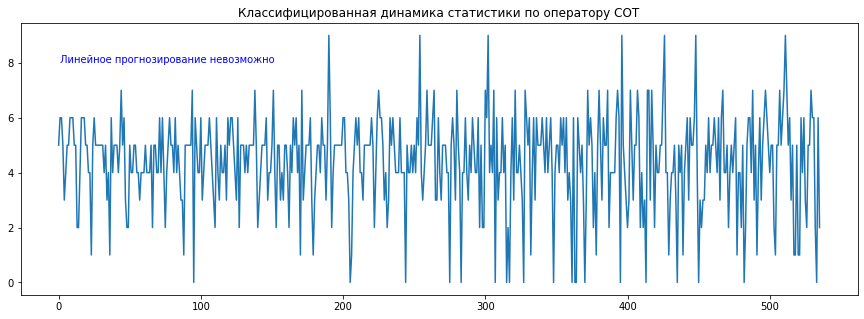

In [5]:
# Результат
print(npOI[0:25], end='\n\n')
plt.figure(figsize=(15,5))
plt.title("Классифицированная динамика статистики по оператору СОТ")
plt.text(1, 8, "Линейное прогнозирование невозможно", color = 'blue')
plt.plot(OI)

# Параметры и функции


In [6]:
# ------------ ВВОДНЫЕ ------------ #

interval = 5                                                                     # Размерность окна

entry_ssq = 10                                                                   # Пороговая СУММКВРАЗНОСТЬ

min_ssq_target = 10                                                               # Минимальное количество СУММКВРАЗНОСТей

max_deviation = 1                                                                # Стандартное отклонение, не более

max_dev_fr_intmean = 0.335                                                       # Отклонение от целого среднего, не более

# ------------ РАСЧЕТНЫЕ ------------ #

full_length = len(OI)
cut_length = full_length - interval

shift = 1

In [7]:
def sum_squares_differences(first_array, second_array):
    if not len(first_array) == len(second_array):
        raise Exception("Input arrays are different sizes")
    array_len = len(first_array)
    total = []
    squares = []
    for i in range(array_len):
        squares.append((first_array[i] - second_array[i])**2)
    total = sum(squares)
    return total

# Создание цифрового ряда

In [8]:
# Отсечка верхних значений X и формирование ряда
setting_X = []
for q in range(full_length):
    aaa = []
    if q < interval:
        continue
    for i in range(interval):
        aaa.append(npOI[q-i-1])
    setting_X.append(aaa)

In [9]:
# Отсечка верхних значений Y
setting_Y = []
for w in range(full_length):
    if w < interval:
        continue
    setting_Y.append(npOI[w])

In [10]:
# Результат
print(setting_Y[0:5], end='\n\n')
print(setting_X[0:5])

[4, 5, 5, 6, 6]

[[3, 5, 6, 6, 5], [4, 3, 5, 6, 6], [5, 4, 3, 5, 6], [5, 5, 4, 3, 5], [6, 5, 5, 4, 3]]


# 1-й массив - количество совпадений в прошлом, удовлетворяющих условиям параметров

In [11]:
# Сдвиг на строку, затем сравнение всех сумм квадратов разностей для всех комбинаций
matches = []
for i in range(cut_length):
    if i < shift:
        matches.append(0)
        continue
    for q in range(i):
        abc = sum_squares_differences(setting_X[i], setting_X[i-q])
        if abc >= entry_ssq:
            if q > 0:
                matches[i] += 1
            else:
                matches.append(1)
        else:
            if q > 0:
                matches[i] += 0
            else:
                matches.append(0)

In [12]:
# Обнуление количества совпадений, ниже минимального порога
for w in range(cut_length):
    if matches[w] < min_ssq_target:
        matches[w] = 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 11, 10, 0, 0, 0, 0, 16, 18, 19, 19, 20, 12]



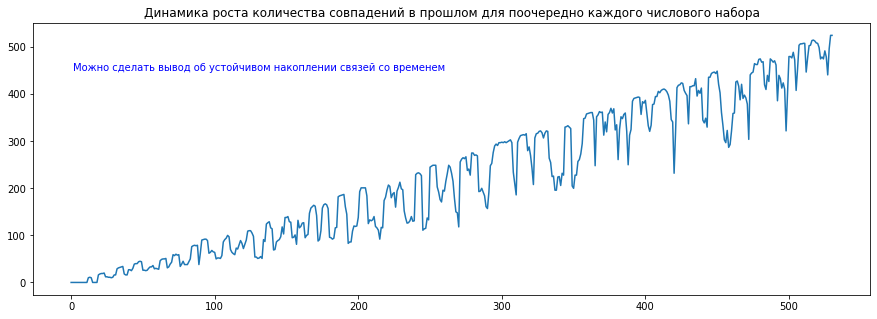

In [13]:
# Результат
print(matches[0:25], end='\n\n')
plt.figure(figsize=(15,5))
plt.title("Динамика роста количества совпадений в прошлом для поочередно каждого числового набора")
plt.text(1, 450, "Устойчивое накопление связей со временем", color = 'blue')
plt.plot(matches)

# 2-й и 3-й массив: среднее и стандартное отклонение среди всех Y-ков, которые соответствуют СУММКВРАЗНОСТям, оказавшимся в выборке